In [1]:
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
import time

shap.initjs()

## Data preprocessing

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head(1)

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1


In [3]:
members = pd.read_csv('members.csv')
members.head(1)

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920


### Adding users with date processing

In [4]:
def process_date(df, columns):
    for column in columns:
        df[column + '_year'] = df[column].apply(lambda x: int(str(x)[0:4]))
        df[column + '_month'] = df[column].apply(lambda x: int(str(x)[4:6]))
        df[column + '_date'] = df[column].apply(lambda x: int(str(x)[6:8]))
        
    df.drop(columns, axis=1, inplace=True)
    return df

members = process_date(members, ['registration_init_time', 'expiration_date'])

train = train.merge(members, on='msno', how='left')
test = test.merge(members, on='msno', how='left')
del members

### One hot encoding of songs

In [5]:
songs = pd.read_csv('songs.csv')
songs.head(1)

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0


In [6]:
songs_genres = songs['genre_ids'].apply(lambda x: [int(v) for v in str(x).split('|') if v != 'nan'])

In [7]:
unique_genres = None
for genres in songs_genres:
    genres = np.array(genres)
    if unique_genres is None:
        unique_genres = genres
        continue
    unique_genres = np.unique(np.concatenate([unique_genres, genres]))

In [8]:
one_hot = np.zeros((len(songs_genres), len(unique_genres)))
for song_id, song_genres in enumerate(songs_genres):
    for genre in song_genres:
        genre_id = list(unique_genres).index(genre)
        one_hot[song_id, genre_id] = 1
        
for genre_id, genre in enumerate(unique_genres):
    songs['genre_' + str(int(genre))] = one_hot[:, genre_id]

In [9]:
songs = songs.drop(['genre_ids'], axis=1)

train = train.merge(songs, on='song_id', how='left')
del songs

### Adding publication year of each song

In [10]:
extra_songs = pd.read_csv('song_extra_info.csv')
extra_songs.head(1)

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043


In [11]:
def isrc_to_year(isrc):
    if type(isrc) == str:
        val = int(isrc[5:7])
        if val > 17:
            return 1900 + val
        else:
            return 2000 + val
    else:
        return np.nan
    
extra_songs['song_year'] = extra_songs['isrc'].apply(isrc_to_year)

train = train.merge(extra_songs, on='song_id', how='left')
songs = train[['song_id', 'artist_name', 'name', 'language']]
train.drop(['isrc', 'name'], axis=1, inplace=True)
del extra_songs 

### Counters: for each user count interactions with same song and artist in the past

In [12]:
from datetime import datetime

start = datetime.now()

past_records = pd.DataFrame().append(train.iloc[0])
all_genres = [col for col in train if col.startswith('genre_')]

def count_interaction(df, column):
    interaction_col = column + '_interaction'
    df['interactions'] = 0
    return df[['msno', column, 'interactions']].groupby(['msno', column], as_index=False).cumcount()

train['artist_interaction'] = count_interaction(train, 'artist_name')
train['song_interaction'] = count_interaction(train, 'song_id')
train.drop(columns=['interactions'], inplace=True)

### Categorize columns

In [13]:
train = train.fillna(0)

small_train = train[:5000]
full_train = train

In [14]:
len(train)

7377418

In [15]:
train = full_train

In [41]:
X = train.drop(['target'], axis=1)
y = train['target'].values

In [42]:
def prepare_data_for_gbdt(X):
    for col in X.select_dtypes(include=['object']).columns:
        X[col] = X[col].astype('category')
        
    for col in X.select_dtypes(include=['category']).columns:
        X[col] = X[col].cat.codes
        
    return X

In [43]:
songs.head()

,song_id,artist_name,name,language
0,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,Bastille,Good Grief,52.0
1,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,Various Artists,Lords of Cardboard,52.0
2,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,Nas,Hip Hop Is Dead(Album Version (Edited)),52.0
3,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,Soundway,Disco Africa,-1.0
4,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,Brett Young,Sleep Without You,52.0


## Hyperparameter tuning

In [44]:
# Xgboost
params = {}
params['objective'] = 'binary:logistic'
params['tree_method'] = 'gpu_hist'
params['learning_rate'] = 0.2
params['n_estimators'] = 500
params['predictor'] = 'gpu_predictor'

In [49]:
X_param = prepare_data_for_gbdt(X[:10000].copy()).values
y_param = y[:10000]
X_train, X_test, y_train, y_test = train_test_split(X_param, y_param, test_size=0.1)

In [53]:
from sklearn.model_selection import GridSearchCV

params1 = {
    'max_depth':range(3, 11, 2),
    'min_child_weight' : range(1, 9, 2)
}

gs1 = GridSearchCV(estimator=xgb.XGBClassifier(**params), param_grid=params1, scoring='roc_auc')
gs1.fit(X_train, y_train)
gs1.best_params_, gs1.best_score_

({'max_depth': 9, 'min_child_weight': 1}, 0.8514296238561151)

In [57]:
params1 = {
    'max_depth':[8, 9, 10],
    'min_child_weight' : [0, 0.25, 0.5, 1, 2]
}

gs1 = GridSearchCV(estimator=xgb.XGBClassifier(**params), param_grid=params1, scoring='roc_auc')
gs1.fit(X_train, y_train)
gs1.best_params_

{'max_depth': 10, 'min_child_weight': 0.25}

In [55]:
params2 = {
    'subsample': [i / 10.0 for i in range(6, 10)],
    'colsample_bytree' : [i / 10.0 for i in range(6, 10)]
}

gs2 = GridSearchCV(estimator=xgb.XGBClassifier(**params), param_grid=params2, scoring='roc_auc')
gs2.fit(X_train, y_train)
gs2.best_params_, gs2.best_score_

({'colsample_bytree': 0.6, 'subsample': 0.9}, 0.8479131236600006)

In [59]:
params2 = {
    'subsample':[i / 100.0 for i in range(50, 70, 4)],
    'colsample_bytree' : [i / 100.0 for i in range(80, 100, 4)]
}

gs2 = GridSearchCV(estimator=xgb.XGBClassifier(**params), param_grid=params2, scoring='roc_auc')
gs2.fit(X_train, y_train)
gs2.best_params_, gs2.best_score_

({'colsample_bytree': 0.96, 'subsample': 0.66}, 0.8421167211319881)

In [56]:
params3 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 2, 5, 10, 100]
}

gs3 = GridSearchCV(estimator=xgb.XGBClassifier(**params), param_grid=params3, scoring='roc_auc')
gs3.fit(X_train, y_train)
gs3.best_params_, gs3.best_score_

({'reg_alpha': 1}, 0.8511134443007901)

In [60]:
params3 = {
    'reg_alpha':[0.1, 0.2, 0.5, 0.7, 0.9, 1, 1.2, 1.5, 2]
}

gs3 = GridSearchCV(estimator=xgb.XGBClassifier(**params), param_grid=params3, scoring='roc_auc')
gs3.fit(X_train, y_train)
gs3.best_params_, gs3.best_score_

({'reg_alpha': 1}, 0.8511134443007901)

In [61]:
params4 = {
    'objective': ['binary:logistic', 'reg:squarederror', 'binary:hinge']
}

gs4 = GridSearchCV(estimator=xgb.XGBClassifier(**params), param_grid=params4, scoring='roc_auc')
gs4.fit(X_train, y_train)
gs4.best_params_, gs4.best_score_

({'objective': 'binary:logistic'}, 0.8466262473461621)

In [63]:
params5 = {
    'n_estimators': [300, 500, 700, 900, 1100]
}

gs5 = GridSearchCV(estimator=xgb.XGBClassifier(**params), param_grid=params5, scoring='roc_auc')
gs5.fit(X_train, y_train)
gs5.best_params_, gs5.best_score_

({'n_estimators': 300}, 0.8501347677578623)

In [65]:
params5 = {
    'n_estimators': [100, 150, 200, 250, 300, 350]
}

gs5 = GridSearchCV(estimator=xgb.XGBClassifier(**params), param_grid=params5, scoring='roc_auc')
gs5.fit(X_train, y_train)
gs5.best_params_, gs5.best_score_

({'n_estimators': 150}, 0.8514738862117766)

In [66]:
final_params = params
final_params['objective'] = 'binary:logistic'
final_params['tree_method'] = 'gpu_hist'
final_params['learning_rate'] = 0.1
final_params['n_estimators'] = 150
final_params['reg_alpha'] = 1
final_params['subsample'] = 0.66
final_params['colsample_bytree'] = 0.96
final_params['max_depth'] = 10
final_params['min_child_weight'] = 0.25

# Task 1

In [67]:
gbdt = xgb.XGBClassifier(**final_params)
gbdt.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.96, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=0.25, missing=nan,
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=150, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=0.66,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

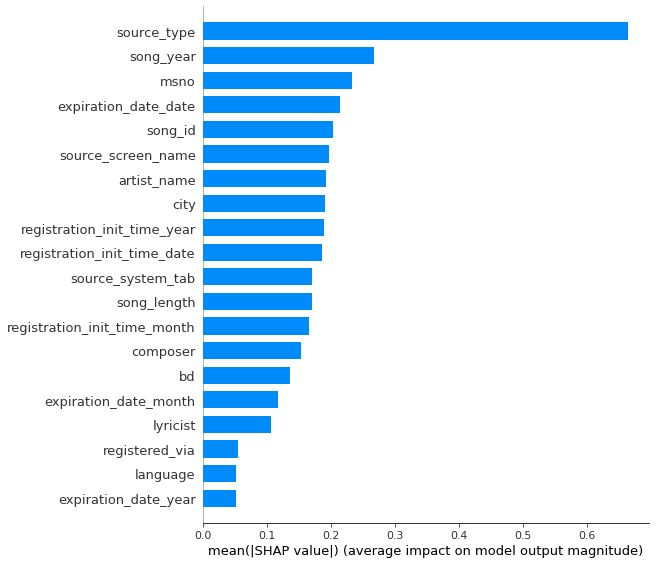

In [68]:
expl = shap.TreeExplainer(gbdt)

shap.summary_plot(expl.shap_values(X_train), X.columns, plot_type='bar')

In [70]:
# Evaluation
kf = KFold(5)

X_raw_gbdt = prepare_data_for_gbdt(X).values

ground_truths = []
predictions = []
start = datetime.now()
for iteration, (train_idxs, test_idxs) in enumerate(kf.split(X_raw_gbdt)):
    print('fold number', iteration + 1)
    X_train, X_test = X_raw_gbdt[train_idxs], X_raw_gbdt[test_idxs]
    y_train, y_test = y[train_idxs], y[test_idxs]

    gbdt = xgb.XGBClassifier(**final_params)
    gbdt.fit(X_train, y_train)
    prediction = gbdt.predict(X_test)
    
    ground_truths.append(y_test)
    predictions.append(prediction)
print(datetime.now() - start)

fold number 1
fold number 2
fold number 3
fold number 4
fold number 5
0:08:27.003389


In [71]:
def score_auc(ground_truths, predictions):
    aucs = []
    for gt, pred in zip(ground_truths, predictions):
        roc_auc = roc_auc_score(gt, pred)
        print(roc_auc)
        aucs.append(roc_auc)
    mean_auc = np.mean(aucs)
    print('mean', mean_auc)
    
score_auc(ground_truths, predictions)

0.6998047696676671
0.6678834777828841
0.6438430586598707
0.6241751516401907
0.6083782940763607
mean 0.6488169503653947


# Task 2

In [72]:
train = full_train

In [135]:
X = train.drop(['target'], axis=1)[:500000]
y = train['target'].values[:500000]

## Preparing Word2Vec model

In [136]:
from gensim.models import Word2Vec
import multiprocessing

hidden_dim = 200

def extract_histories(X):
    return X.groupby('msno')['song_id'].apply(list)

def train_word2vec(histories):
    w2v = Word2Vec(window=10, sg=1, hs=0, size=hidden_dim, negative=10, alpha=0.03, min_alpha=0.0007, workers=multiprocessing.cpu_count())
    w2v.build_vocab(histories, progress_per=100)
    w2v.train(histories, total_examples=w2v.corpus_count, epochs=10, report_delay=1)
    print(w2v[w2v.wv.vocab].shape)
    print(w2v)
    w2v.init_sims(replace=True)
    return w2v

In [137]:
histories = extract_histories(X)
len(histories)

13745

In [138]:
w2v = train_word2vec(histories)

(13068, 200)
Word2Vec(vocab=13068, size=200, alpha=0.03)


Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [139]:
example_song_id = 'M9cjhJoFuF3etW4qiz5e4cEuBo0aM3MAj4HtaL2b9cs=' # Lady Gaga Bad Romance

In [140]:
raw_similars = w2v.wv.most_similar(positive=example_song_id)

similars = pd.DataFrame([])
song = songs[songs['song_id'] == example_song_id].drop_duplicates()[['artist_name', 'name', 'language']]
song['similarity'] = 1
similars = similars.append(song)

for song_id, similarity in raw_similars:
    song = songs[songs['song_id'] == song_id].drop_duplicates()[['artist_name', 'name', 'language']]
    song['similarity'] = similarity
    similars = similars.append(song)
    
similars

,artist_name,name,language,similarity
13883,Lady Gaga,Bad Romance,52.0,1.000000
16059,Lady Gaga,Poker Face,52.0,0.736729
24945,Lady Gaga,Judas,52.0,0.720109
23935,Lady Gaga,Paparazzi,52.0,0.717713
13050,Lady Gaga,The Edge Of Glory,52.0,0.697075
9050,Lady Gaga,Monster,52.0,0.687198
12602,Lady Gaga,Speechless,52.0,0.678224
25253,Lady Gaga,Telephone,52.0,0.660624
90782,Lady Gaga,LoveGame,52.0,0.659846
13895,Lady Gaga,Born This Way,52.0,0.645819


## Word2Vec as a recommender system

In [141]:
def create_user_embeddings(X, word2vec_model):
    user_embeddings = {}
    users = np.unique(X['msno'].values)
    
    for user_id in users:
        user_songs = X[X['msno'] == user_id]['song_id']

        user_embedding = user_songs.apply(lambda song_id: word2vec_model.wv[song_id] if song_id in word2vec_model.wv else np.zeros(hidden_dim)).mean()
        user_embeddings[user_id] = user_embedding 
    
    return user_embeddings

In [149]:
from scipy import spatial

def similarity_distance(song_id, user_id, w2v, user_emb):
    user_embedding = user_emb[user_id] if user_id in user_emb else np.zeros(hidden_dim)
    song_embedding = w2v.wv[song_id] if song_id in w2v.wv else np.zeros(hidden_dim)
    # cosine distance between zero vectors
    if np.linalg.norm(user_embedding) < 1e-9 or np.linalg.norm(song_embedding) < 1e-9:
        return 0
    
    distance = spatial.distance.cosine(user_embedding, song_embedding)
    return distance

def compute_score(X_test, y_test, w2v, user_emb):
    user2emb = X_test['msno'].apply(lambda user_id: user_emb[user_id] if user_id in user_emb else np.zeros(hidden_dim)).values
    song2emb = X_test['song_id'].apply(lambda song_id: w2v.wv[song_id] if song_id in w2v.wv else np.zeros(hidden_dim)).values
    
    scores = [np.dot(song_embedding, user_embedding) for user_embedding, song_embedding in zip(user2emb, song2emb)]
    return scores

In [143]:
user_emb = create_user_embeddings(X, w2v)

In [150]:
# Evaluation
kf = KFold(5)

word2vec_ground_truths = []
word2vec_predictions = []
start = datetime.now()

for iteration, (train_idxs, test_idxs) in enumerate(kf.split(X)):
    print('fold number', iteration + 1)
    X_train, X_test = X.iloc[train_idxs], X.iloc[test_idxs]
    y_train, y_test = y[train_idxs], y[test_idxs]

    prediction = compute_score(X_test, y_test, w2v, user_emb)
    
    word2vec_ground_truths.append(y_test)
    word2vec_predictions.append(prediction)
print(datetime.now() - start)

fold number 1
fold number 2
fold number 3
fold number 4
fold number 5
0:00:06.465770


In [151]:
score_auc(word2vec_ground_truths, word2vec_predictions)

0.5326133873713952
0.5218881236594162
0.5298675120412915
0.5118417156551709
0.5120800676876656
mean 0.5216581612829879


# Stacking GBDT with Word2Vec embeddings

In [154]:
X = train.drop(['target'], axis=1)[:50000]
y = train['target'].values[:50000]

In [155]:
def prepare_word2vec(X):
    histories = extract_histories(X)
    w2v = train_word2vec(histories)
    user_emb = create_user_embeddings(X, w2v)
    X['similarity'] = X[['msno', 'song_id']].apply(lambda row: similarity_distance(row['song_id'], row['msno'], w2v, user_emb), axis=1)
    return X

X_sim = prepare_word2vec(X.copy())

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


(1853, 200)
Word2Vec(vocab=1853, size=200, alpha=0.03)


In [156]:
gbdt = xgb.XGBClassifier(**final_params)
X_sim = prepare_data_for_gbdt(X_sim).values
gbdt.fit(X_sim, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.96, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=0.25, missing=nan,
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=150, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=0.66,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

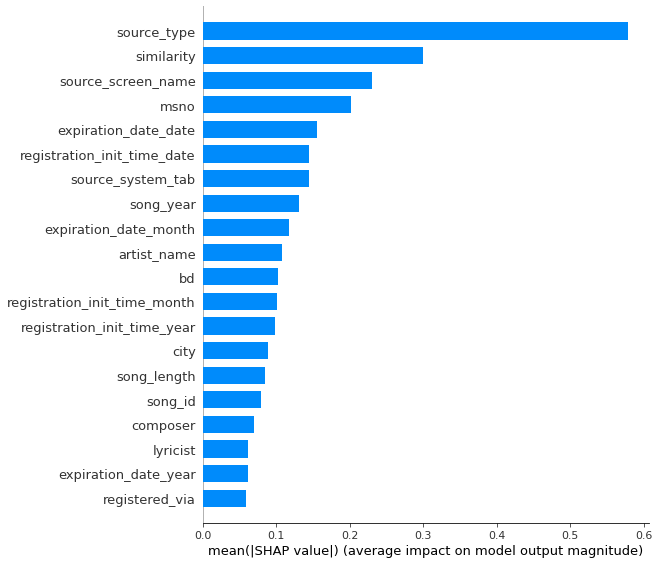

In [157]:
expl = shap.TreeExplainer(gbdt)

shap.summary_plot(expl.shap_values(X_sim), list(X.columns) + ['similarity'], plot_type='bar')

In [158]:
X = train.drop(['target'], axis=1)[:500000]
y = train['target'].values[:500000]

X_sim = prepare_word2vec(X.copy())
X_sim = prepare_data_for_gbdt(X_sim).values

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


(13068, 200)
Word2Vec(vocab=13068, size=200, alpha=0.03)


In [159]:
# Evaluation
kf = KFold(5)

stack_ground_truths = []
stack_predictions = []
start = datetime.now()
for iteration, (train_idxs, test_idxs) in enumerate(kf.split(X_sim)):
    print('fold number', iteration + 1)
    X_train, X_test = X_sim[train_idxs], X_sim[test_idxs]
    y_train, y_test = y[train_idxs], y[test_idxs]

    gbdt = xgb.XGBClassifier(**final_params)
    gbdt.fit(X_train, y_train)
    prediction = gbdt.predict(X_test)
    
    stack_ground_truths.append(y_test)
    stack_predictions.append(prediction)
print(datetime.now() - start)

fold number 1
fold number 2
fold number 3
fold number 4
fold number 5
0:01:02.614166


In [160]:
score_auc(stack_ground_truths, stack_predictions)

0.6688058744167361
0.6765992711363935
0.6642037279145565
0.6595314328319601
0.6455241996258273
mean 0.6629329011850946


По shap_values видно, что соответствующий эмбеддинг оказывает влияние и по метрике ROC AUC -- в положительную сторону.

Но переигравшись с параметрами скор упал с 0.71 до 0.65 в Xgboost :(